## Data preparation and sanitization

In [26]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()
## Usable columns: ['time_spent_risk', 'cells', 'selfish', 'time_spent_prop', 'count_effort', 
## 'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']
#df["effort"] = (1/df['time_spent_prop'] ) * (1/df['count_effort'])
df_effort = df[['time_spent_prop', 'count_effort']]
df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

MAX_ACCEPTABLE_MIN_OFFER = 150
df = df[df['min_offer'] <= MAX_ACCEPTABLE_MIN_OFFER]

NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [27]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### Benchmark

In [28]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, fit_kwargs=None, predict_kwargs=None, augment_data=None):
    """
    :param model: model with fit/predict methods
    :param X: features
    :param y: target
    :param cv: (int) cross validation splits
    :param fit_kwargs: (dict) kwargs for fit
    :param predict_kwargs: (dict) kwargs for predict
    :param augment_data: (None|1|2) 1: random, 2: upsample    
    """
    # We make sure original values aren't modified, even by mistake
    X = np.copy(X)
    y = np.copy(y)
    
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        if augment_data:
            upsample = augment_data==2
            xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain, upsample=upsample)
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

def process_benchmarks(models_dict, X, y, cv=5, fit_kwargs=None, predict_kwargs=None, augment_data=None):
    """
    Benchmark multiple models using the same augmented data to spare time from data augmentation
    :param models_dict: {key:model} dict of models with fit/predict methods
    :param X: features
    :param y: target
    :param cv: (int) cross validation splits
    :param fit_kwargs: (dict) kwargs for fit
    :param predict_kwargs: (dict) kwargs for predict
    :param augment_data: (None|1|2|list) None: no data-augmentation, 1: random, 2: upsample  
    :returns: dict of dataframe results
    """
    X = np.copy(X)
    y = np.copy(y)
    if not isinstance(augment_data, (list, tuple)):
        augment_data = [augment_data]
    benchmark_results = {key:[] for key in models_dict}
    kf = KFold(n_splits=cv)
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        for augment_data_step in augment_data:
            if augment_data_step:
                upsample = augment_data_step==2
                xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain, upsample=upsample)
            xTest, yTest = X[test_index], y[test_index]
            for key, model in models_dict.items():
                benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
                nKey = key
                if augment_data_step:
                    nKey += "_da" + str(augment_data_step)
                nKey_results = benchmark_results.get(nKey, [])
                nKey_results.append(benchmark_result)
                benchmark_results[nKey] = nKey_results
    return {key: pd.DataFrame(results) for key, results in benchmark_results.items()}
        
            

**Keras Model**

In [29]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)

def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(8, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def _keras_linear_regression(loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_linear_regression(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_linear_regression(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    
def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

In [30]:
# #sci-kit like training
# sm = keras_model("mse") 
# history = sm.fit(xTrain, yTrain, validation_split=0.33, epochs=100, batch_size=64, verbose=0)
# loss_hist = pd.DataFrame(data={'loss': history.history['loss']})
# loss_hist.plot(figsize=(30,10))
# smPredict = sm.predict(xTest, batch_size=128)

# out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(smPredict)})
# stl = sm.evaluate(xTest, yTest, verbose=0)
# print("Results: %2.2f (%.2f) MSE, Scalar test loss: %.2f" % (smPredict.mean(), smPredict.std(), stl))
# #out_data.plot(figsize=(30,10))

**Featureless model (fixed value)**

In [31]:
class FeatureLessModel(object):
    def __init__(self, max_value, loss=None):
        self.value = None
        self.max_value = max_value
        self.loss = loss or avg_loss_ratio
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        min_loss = float('inf')
        best_value = 0
        for value in np.arange(self.max_value):
            fixedPredict = np.ones_like(yTrain) * value
            loss = self.loss(yTrain, fixedPredict)
            if loss < min_loss:
                min_loss = loss
                best_value = value
        self._trained = True
        self.value = best_value
    
    def predict(self, xTrain, **kwargs):
        if not self._trained:
            raise ValueError("The model first need to be trained!!!")
        res = np.ones((xTrain.shape[0], 1) ) * self.value
        return res

    


**Convervative model**

In [32]:
class ConservativeModel(object):
    def __init__(self, max_value):
        self.value = None
        self.max_value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self.value = self.max_value - 1
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.ones((xTest.shape[0], 1)) * self.value

**Linear/Logistic regression**

In [33]:
from sklearn.linear_model import LinearRegression, LogisticRegression

**Random**

In [34]:
class RandomModel(object):
    def __init__(self, max_value):
        self.value = max_value
        self._trained = False

    def fit(self, xTrain, yTrain, **kwargs):
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if not self._trained:
            raise ValueError("The model should first be trained")
        return np.random.random((xTest.shape[0], 1)) * self.value

**Random Forest**

In [35]:
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor

**Clustering**

In [47]:
import copy
from sklearn.cluster import KMeans, MeanShift, DBSCAN, SpectralClustering, Birch, MiniBatchKMeans, AffinityPropagation
from sklearn.mixture import BayesianGaussianMixture


class ClusterModel(object):
    def __init__(self, **kwargs):
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "birch": Birch,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                    "affinity": AffinityPropagation,
                    "bayes": BayesianGaussianMixture,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        super().__init__()
        self.clustersClasses = None
        self._trained = False
    
    def fit(self, xTrain, yTrain, **kwargs):
        self.base_model.fit(xTrain)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        for cluster in range(len(labels)):
            values = yTrain[self.base_model.labels_==cluster]
            clustersClasses[cluster] = values.mean() + values.std()
        self.clustersClasses = clustersClasses
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        return self.clustersClasses[predClusters]

class ClusterExtModel(object):
    def __init__(self, **kwargs):
        if "sub_model" in kwargs:
            self.sub_model = kwargs.pop("sub_model")
        else:
            self.sub_model = FeatureLessModel(
            )
        if "base_model" in kwargs:
            base_model_ = kwargs.pop("base_model")
            if isinstance(base_model_, str):
                models = {
                    "kmeans": KMeans,
                    "meanshift": MeanShift,
                    "birch": Birch,
                    "spectral": SpectralClustering,
                    "minibatch": MiniBatchKMeans,
                    "affinity": AffinityPropagation,
                    "bayes": BayesianGaussianMixture,
                }
                self.base_model = models.get(base_model_, MeanShift)(**kwargs)
            else:
                self.base_model = base_model_
        else:
            self.base_model = MeanShift(**kwargs)
        self._trained = False
        self.sub_models = None
        self.max_value = MAX_GAIN
        
    def fit(self, xTrain, yTrain, **kwargs):        
        self.base_model.fit(xTrain, yTrain, **kwargs)
        labels = np.array([item for item in np.unique(self.base_model.labels_) if item >= 0])
        clustersClasses = np.zeros_like(labels)
        sub_models = []
        for cluster in range(len(labels)):
            sub_model = copy.deepcopy(self.sub_model)
            mask = self.base_model.labels_==cluster
            sub_model.fit(xTrain[mask], yTrain[mask])
            sub_models.append(sub_model)
        # We use an array instead of a list for better indexing
        #self.clustersClasses = [sub_model.value for sub_model in sub_models]
        self.sub_models = np.array(sub_models)
        self._trained = True
    
    def predict(self, xTest, **kwargs):
        if self._trained is None:
            raise ValueError("Model not trained yet")
        predClusters = self.base_model.predict(xTest)
        sub_models = self.sub_models[predClusters]
        preds = []
        dummy_x = np.array([0])
        for idx in range(xTest.shape[0]):
            preds.append(sub_models[idx].predict(np.array([xTest[idx]])))
        res = np.array(preds).ravel()
        return res
        #return self.clustersClasses[predClusters]
            

** Data augmentation **

In [37]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES, max_gain=MAX_GAIN):
        self.size = size
        self.nb_features = nb_features
        self.max_gain = max_gain
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=10, upsample=True, include_xy=False, retarget=False, distribution=False, combine=False):
        """
        :param size: (int) size of the new generated dataset
        :param distance: (int) distance between parents or similar items
        :param upsample: (bool) if True, try balance the dataset
        :param include_xy: (bool) if True, include xTrain and yTrain to the data (on top of size items)
        :param retarget: (bool) if True, set all targets to the nearest higher multiple of distance without generating new samples
        :param distribution: (bool) if True, create new sample based on percentiles of features's std
        :param combine: (bool) if True: combine different methods (dist + retarget)
        """
        
        size = size or self.size or len(xTrain) * 4
        if combine:
            if distribution:
                xTrain, yTrain = self.dist_resample(xTrain, yTrain, size)
        else:
            if retarget:
                return self.retarget(xTrain, yTrain, distance)

            if distribution:
                return self.dist_resample(xTrain, yTrain, size)
    
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: minimize selection of target with only one sample
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = []
        yRes = []
        if include_xy:
            xRes.extend(xTrain)
            yRes.extend(yTrain.ravel())
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<target+distance) & (yTrain.ravel()>=(target))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = np.random.randint(self.nb_features)
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        xRes = np.array(xRes)
        yRes = np.array(yRes)
        if combine and retarget:
            return self.retarget(xRes, yRes, distance)
        return np.array(xRes), np.array(yRes)

    def retarget(self, xTrain, yTrain, distance=10):
        yNew = np.zeros(yTrain.shape[0])
        for y in np.arange(self.max_gain, 0, -distance):
            mask = (yTrain <= y) & (yTrain > y-distance)
            yNew[mask] = y + distance
        yNew = np.array(yNew)
        yNew[yNew > self.max_gain] = self.max_gain
        return xTrain, yNew
    
    def dist_resample(self, xTrain, yTrain, size=None, std_ratio=0.1):
        size = size or self.size or len(xTrain) * 4
        xTrain_mean = xTrain.mean()
        xTrain_std = xTrain.std()
        xNew = []
        yNew = []
        for _ in range(size):
            idx = np.random.randint(0, xTrain.shape[0])
            x = np.random.normal(xTrain[idx], xTrain_std*std_ratio)
            y = yTrain[idx]
            xNew.append(x)
            yNew.append(y)
        return np.array(xNew), np.array(yNew)
            

    def fit_resample(self, xTrain, yTrain, size=None, distance=5, include_xy=True):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance, include_xy=include_xy)

**Baseline models**

In [44]:
from sklearn.svm import SVC

benchmark_models = {
    #Featureless:
    #"random": RandomModel(MAX_GAIN),
    #"conservative": ConservativeModel(MAX_GAIN),
    "featureless": FeatureLessModel(MAX_GAIN),
    "svc": SVC(gamma='auto') 
#     "linear_regressor": LinearRegression(copy_X=False),
#     "linear_regressor_mse": keras_linear_regression(loss="mse"),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
featureless,26.897619,0.218127,24.028855,963.0,1510.321429,0.066825
featureless_da2,46.826190,0.407541,35.704154,1676.0,3275.757937,0.200000
svc,26.897619,0.218127,24.028855,963.0,1510.321429,0.066825
svc_da2,83.296825,0.730387,41.844838,2983.0,8825.682540,0.590952


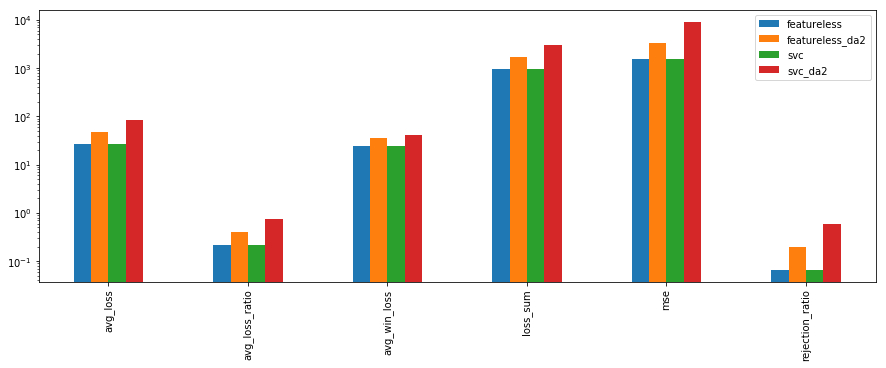

In [45]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Clustering based models**

In [40]:
# benchmark_models = {
#     #Cluster-based
    "affinity": ClusterModel(base_model="affinity"),
#     "bayes": ClusterModel(base_model="bayes", n_components=8),
#     "birch": ClusterModel(base_model="birch"),
#     "kmeans": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift": ClusterModel(base_model="meanshift", cluster_all=True),
    "affinity_ext": ClusterExtModel(base_model="affinity"),
#     "bayes_ext": ClusterExtModel(base_model="bayes", n_components=8),
#     "birch_ext": ClusterExtModel(base_model="birch"),
#     "kmeans_ext": ClusterModel(base_model="kmeans", n_clusters=16),
    "meanshift_ext": ClusterExtModel(base_model="meanshift", cluster_all=True),
# }

results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

In [41]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))

**Other models**

In [42]:
benchmark_models = {
    # Regression
    #"random_forest_regr": RandomForestRegressor(min_samples_leaf=5),
    'logistic_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
    "nn_regression_mse": keras_model(loss="mse"),
    "nn_regression_ext": keras_model(loss=loss_tf),
    
    # Classification
    #"random_forest": RandomForestClassifier(min_samples_leaf=5),#max_depth=3, random_state=0, n_estimators=10),
}

results = dict()
# for key, model in benchmark_models.items():
#     results[key] = process_benchmark_cv(model, x, y.ravel())
#     results[key+"_da"] = process_benchmark_cv(model, x, y.ravel(), augment_data=2)
#results = {key: process_benchmark_cv(model, x, y.ravel()) for key, model in benchmark_models.items()}
results = process_benchmarks(benchmark_models, x, y.ravel(), augment_data=[None, 2])
results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
logistic_regression,26.913492,0.219422,23.429033,963.000000,1543.257937,0.072540
logistic_regression_da2,76.171429,0.658550,51.293590,2727.000000,7904.309524,0.435714
nn_regression_ext,77.175116,0.712859,27.687641,2763.257286,7563.734904,0.653333
nn_regression_ext_da2,74.423241,0.670369,24.503287,2667.342431,7410.005187,0.591270
nn_regression_mse,76.479384,0.703860,27.857640,2741.142844,7507.776082,0.641429
nn_regression_mse_da2,72.769712,0.676564,24.229014,2604.922695,7064.034781,0.620000


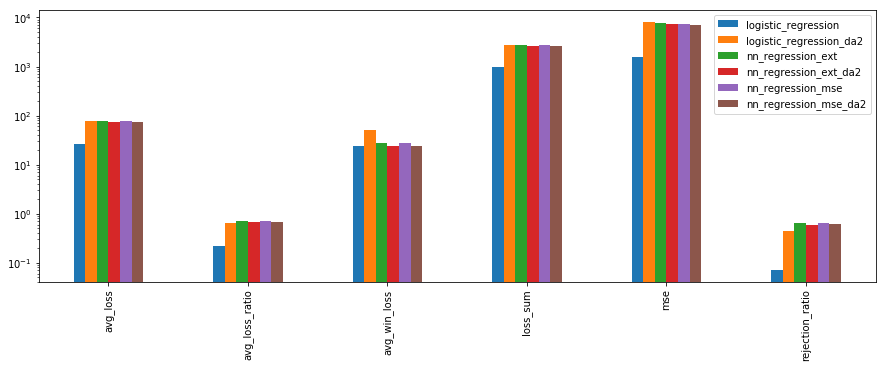

In [43]:
df_results_mean = pd.DataFrame(results_mean)
df_results_std = pd.DataFrame(results_std)
df_results_mean.plot.bar(logy=True, figsize=(15, 5))